# Content Based Recommender System
**GROUP 12** : Divyam Rana, Rinaldo Patel, Siddhart Kant, Yash Kothari

## About our Project

The exponential growth of digital content has made it increasingly difficult for users to discover relevant articles tailored to their interests. Our project aims to develop a content-based recommendation system that clusters and suggests relevant articles without relying on predefined labels. This system will enhance user engagement by providing personalized reading recommendations, ensuring that high-quality content reaches the right audience, and increasing retention rates on news platforms.

### Business Relevance:
Traditional recommendation systems, based on simple keywords or broad demographic data end up missing the mark to grasp what the readers actually care about, which leads to lower  engagement rate, high bounce rates and major revenue loss from ads. For CNNs Daily Mail thousands of articles published, it's easy for great content to be buried. That’s where our project comes in. Our recommender system will:
- Improve **user engagement** by delivering personalized recommendations leading to longer session durations, lower bounce rates, and increased content consumption.
- Help publishers **identify emerging trends** and repurpose relevant articles.
- **Increase ad revenue** through targeted content delivery, improving ROI for advertisers and boosting programmatic ad revenue.
- **Scale efficiently** to handle vast amounts of news data in real time and allowing them to focus on higher-value editorial strategies.
  
### Real-World Applications:
The insights from our project have multiple business applications:
- **News Media:** Personalized article recommendations to increase user dwell time.
- E-Commerce & Marketing: Content recommendations based on user interest.
- Academic Research: Automated categorization of research papers for better discoverability.

### Problem Statement
In today’s fast paced, reel-scrolling digital world, keeping readers engaged is a major challenge for media companies. People are constantly bombarded with news, and if they don’t find content that truly interests them, they quickly lose interest and move on. The main objective of our project is to create an intelligent recommendation system for news articles that enhances content discoverability without requiring manual categorization. Our specific objectives include:
- Identifying patterns in large-scale unstructured text data.
- Implementing NLP techniques to extract meaningful insights.
- Applying unsupervised learning methods such as topic modeling and document similarity heuristics.
- Developing a content-based recommender system to improve user engagement.
This system will enhance user engagement, improve content discovery, and provide a seamless reading experience by reducing the effort required to find relevant articles. The recommender will be designed for news platforms, academic journals, or online media, ensuring that users receive high-quality, contextually relevant content suggestions.

In [10]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk import bigrams, trigrams
from tqdm import tqdm
import notification_nltf as ntf
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
import nltk
from string import punctuation
from nltk.stem import PorterStemmer,WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, PCA
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
from kneed import KneeLocator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
import pickle

# Gensim
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We are limiting the number of articles to 100K to reduce the processing times and overcome computational hurdles

In [ ]:
# Loading the dataset - Limiting to 100K
df = pd.read_parquet('final_dataset.parquet')
df = df.iloc[:100_000]

## Preprocess and Data Cleanup

## **Data Cleaning**



In order to remove irrelevant information and reduce the noise in the data. We perform multiple data cleaning steps for the achieving the same. The following are the specific tasks that were performed.

`clean_text(sentence):` This function removes unnecessary elements from the text, such as URLs, Unicode characters (e.g., emojis), punctuation, and digits, ensuring a clean and standardized format.

**KEY CLEANING STEPS:**

- **Removing URL links**  
  URL links such as `CNN.com` etc. in the articles do not contribute towards semantic meaning relevant to textual analysis and If not removed, models might assign importance to specific URLs, which is irrelevant for our task. 

- **Removing unicode characters**  
  Unicode characters such as emojies and foreign symbols do not have meaningful embeddings in traditional NLP models. Special symbols might create unnecessary complexity when tokenizing text.

- **Removing punctuations**  
  Replaces all occurrences of punctuation marks with an empty string ('')

  Punctuation increases the number of unique tokens, which can make models more complex without adding significant value.

- **Removing Digits**  
  Digits represent dates, numbers etc., which do have not much semantic meaning increasing vocabulary size and chances of overfitting thus we remove them as well.

- **POS Tagging**  
  Function converts POS tags into WordNet POS tags, which are required for accurate lemmatization. 

- **Lemmetization**  
  Lemmatization considers the meaning and context of the word helps in normalizing text, improving consistency, and enhancing the performance of NLP models.

- **Tokenisation**
  Tokenizing to relevant individual words after preprocessing

In [29]:
# Function to remove punctuation and lower the word
def clean_text(sentence):
    # removing the URL links
    sentence = re.sub(r'http\S+|www\S+', '', sentence)
    # removing unicode characters - emojis and other characters
    sentence = re.sub(r'[^\x00-\x7F]+', '', sentence)
    # Removing punctuation
    sentence = re.sub(rf'[{punctuation}]', '', sentence)
    # Removing digits
    sentence = re.sub(r'\d+', '', sentence)
    # Lower casing and removing trailing white spaces
    return sentence.lower().strip()

# doing POS tagging
def get_wordnet_pos(word):
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to do lemmetization
def lemmetizer(tokens, corpus, word_count, stop_words, lem):
    assert isinstance(word_count, defaultdict), "Not a defaultdict object"
    assert isinstance(tokens, list), "tokens should be a list"
    assert isinstance(corpus, set), "corpus should be a set"
    pos_tags = nltk.pos_tag(tokens)
    lemmetized_tk = []
    for word, tag in pos_tags:
        if word not in stop_words:
            lemmitized_word = lem.lemmatize(word, pos=get_wordnet_pos(tag))
            lemmetized_tk.append(lemmitized_word)
            #adding to corpus
            corpus.add(lemmitized_word)
            #adding to word_count
            word_count[lemmitized_word] += 1
    return lemmetized_tk, corpus, word_count

In [ ]:
# A function to preprocess the data and create the corpus and tokenize the documents
def corpus_creation(df):
    corpus = set()
    corpus_without_stopwords = set()
    word_count = defaultdict(int)

    stop_words = set(stopwords.words('english'))
    punctuation = string.punctuation

    articles_tokenized = []
    lem = WordNetLemmatizer()

    # Iterate through articles
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        # Cleaning the sentence
        cleaned_article = clean_text(row['article']).split()
        tokens_cleaned, corpus, word_count = lemmetizer(cleaned_article, corpus, word_count, stop_words, lem)
        articles_tokenized.append(tokens_cleaned)
    
    return corpus, corpus_without_stopwords, word_count, articles_tokenized

In [10]:
# Running the function to preprocess the data and create the corpus and tokenize the documents
corpus, corpus_without_stopwords, word_count, articles_tokenized = corpus_creation(df)

100%|██████████| 100000/100000 [20:27<00:00, 81.44it/s]


In [11]:
# Adding tokenized sentence to the dataframe and saving it as parquet to save space
df['tokenized'] = articles_tokenized
df.to_parquet('data_final/datum_with_tokens.parquet', compression='snappy')

## EDA

First we start with checking the number of words in our corpus after preprocessing

In [12]:
# exploring the number of words that we have
print(f"The corpus size is {len(corpus)}")

The corpus size is 330032


Here, we have about 330K words in the corpus

### **N-gram**
We are now using N-grams to see the most frequent sequences for the words. 

We are looking at the `bigram` and `tri-grams` for the corpus. 

N-grams help us visualize the frequentist sequences of words helping us get insights into the documents

Looking at N-grams : Bi-grams and Tri-grams

In [13]:
# Building bi-gram and tri-gram dictionaries
bigram_dict = defaultdict(int)
trigrams_dict = defaultdict(int)

for tokens in tqdm(df['tokenized']):
    # Creating bigrams
    grams = bigrams(tokens)
    for bg in grams:
        bigram_dict[bg] += 1

    # creating trigrams
    grams = trigrams(tokens)
    for tg in grams:
        trigrams_dict[tg] += 1

# sorting and getting top 10
top_10_bigram_dict = sorted(bigram_dict, key=bigram_dict.get, reverse=True)[:10]
top_10_trigram_dict = sorted(trigrams_dict, key=trigrams_dict.get, reverse=True)[:10]

100%|██████████| 100000/100000 [01:28<00:00, 1128.70it/s]


`bigram_dict` and `trigrams_dict` stores the count of each bigram and trigram
`defaultdict(int)`: Automatically initializes missing keys with a value of 0.
 We create bigrams using `bigrams(tokens)` and `trigrams(tokens)` which returns a list of word pairs.

`top_10_bigram_dict` gives us the **top 10** highest occuring 2 word combinations

In [14]:
top_10_bigram_dict

[('united', 'state'),
 ('new', 'york'),
 ('tell', 'cnn'),
 ('last', 'year'),
 ('contribute', 'report'),
 ('official', 'say'),
 ('last', 'week'),
 ('year', 'ago'),
 ('white', 'house'),
 ('prime', 'minister')]

`top_10_trigram_dict` gives us the **top 10** highest occuring 2 word combinations

In [15]:
top_10_trigram_dict

[('president', 'barack', 'obama'),
 ('express', 'commentary', 'solely'),
 ('opinion', 'express', 'commentary'),
 ('new', 'york', 'city'),
 ('cnn', 'student', 'news'),
 ('new', 'york', 'time'),
 ('daily', 'mail', 'reporter'),
 ('tell', 'cnn', 'affiliate'),
 ('world', 'war', 'ii'),
 ('new', 'york', 'cnn')]

Visualizing the `bi-grams` and `tri-grams` combinations

Now lets look at the top 10 most frequent bigrams (two-word sequences) found in the dataset. This visualization helps in understanding the most commonly occurring word pairs and their frequencies.

**Graph Interpretation**
- From the bigram plot we observe that 'united states' occurs most frequently
- "new york" appearing frequently may indicate a geographical focus.
- "tell cnn" as its a cnn dataset, therefore this is expected.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


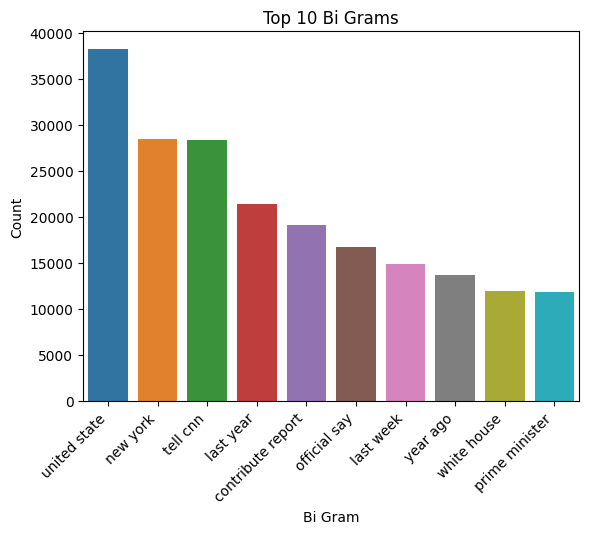

In [16]:
# Plotting the count for the top 10 Bigrams and tri grams

plt.title("Top 10 Bi Grams")
cats = top_10_bigram_dict
vals = [bigram_dict[x] for x in cats]
cats_strings = [" ".join(cat) for cat in cats]
sns.barplot(x = cats_strings, y = vals)
plt.xlabel("Bi Gram")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

Now lets look at the top 10 most frequent trigrams (three-word sequences) found in the dataset. This visualization helps in understanding the most commonly occurring word triplets and their frequencies.

**Graph Interpretation**

- "president barack obama" appears most frequently.
- "express commentary solely" indicates political references.
- "openion express commentary" shows presence of openion views.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


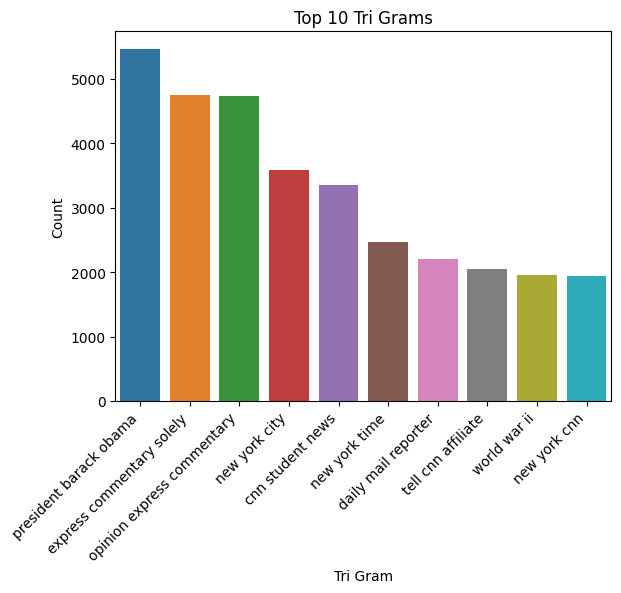

In [17]:
# Plotting the count for the top 10 trigrams and tri grams
plt.title("Top 10 Tri Grams")
cats = top_10_trigram_dict
vals = [trigrams_dict[x] for x in cats]
cats_strings = [" ".join(cat) for cat in cats]
sns.barplot(x = cats_strings, y = vals)
plt.xlabel("Tri Gram")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

### Wordcloud

Now are are looking at the frequent words. A word cloud visualizes larger words that indicate higher frequency, making it easier to identify commonly used words in the text.

**Insights** 
- The top three words in the wordcloud are 'say', 'year', and 'one'. This represents that these words have the highest frequency of occuring in an article.


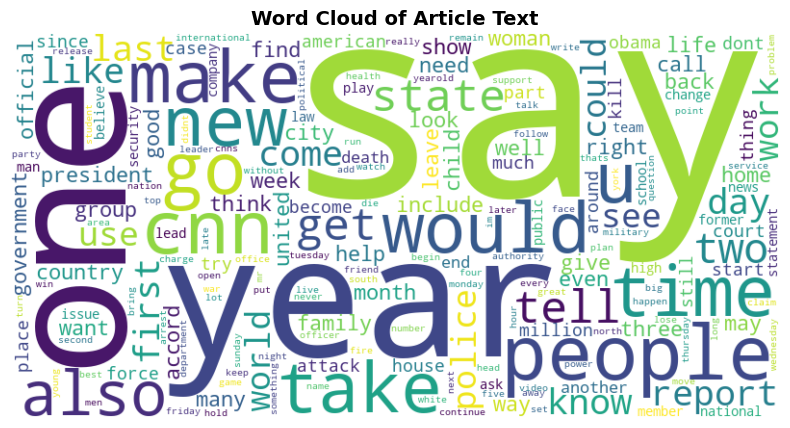

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(word_count)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Article Text", fontsize=14, fontweight="bold")
plt.show()

### Article Length

We are generating a histogram displaying the distribution of article lengths. This visualization helps in understanding the typical length of articles and how they vary across the dataset.

**Graph Interpretation**

- Most articles have fewer than **500** words.
- A small number of articles exceed **1000** words.
- Very few articles exceed **1500** words.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


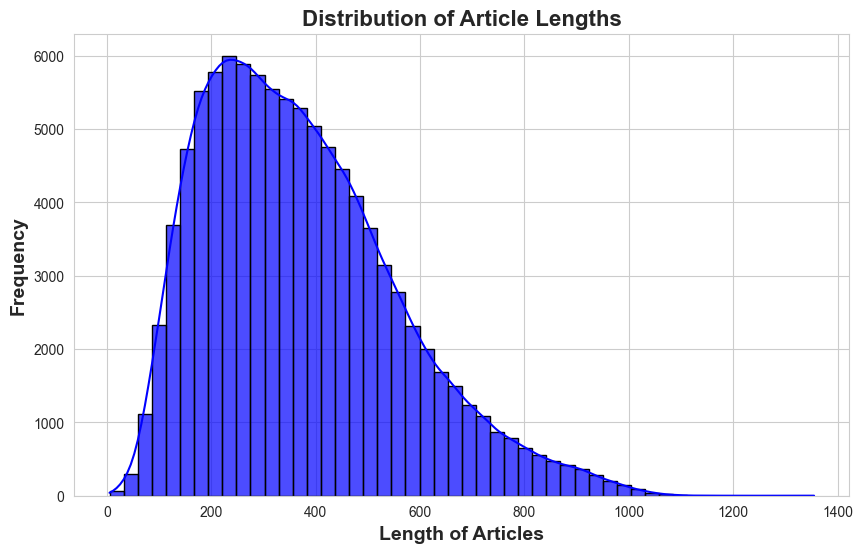

In [19]:
df['length_article'] = df['tokenized'].apply(len)
# Set a seaborn style
sns.set_style("whitegrid")

# Create a larger figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(df['length_article'], bins=50, kde=True, color='blue', edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Length of Articles", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Distribution of Article Lengths", fontsize=16, fontweight='bold')

# Show the plot
plt.show()

### Looking for appropriate corpus size

If we are looking at the count of features that would be required to keep 96% of the values, we would need 328K features. So we are taking 10K features for TF-IDF and Count Vectorizer

In [22]:
word_count_df = pd.DataFrame(list(word_count.items()), columns=["word", "count"])
std_col = (word_count_df.describe()).loc["std"].values[0]
word_count_df[word_count_df['count'] < 2*std_col].shape[0]

328353

## Feature Engineering

Now, we are looking at different models and methodologies for creating the document embeddings for the corpora. The techniques that we are trying out are the following : 
- TF-IDF : In this technique, we are trying to create a embeddings with importance given to less common words
- Bag of Words (BoW) : In this, we are creating the embeddings based on the frequency of occurence for the words
- Neural Network : In this, we are utilizing pre-trained models to create the embeddings

### TF-IDF

- TF-IDF, also known as the product of Term Frequency and Inverse Data Frequency, which is mainly used to understand the importance of words in a document which is related to the corpus. We are mainly using this to discard words which do not carry any meaning.
- We are using TF-IDF here to extract the most significant words for each document. The goal is to identify the key words that can help us in classification or clustering.
- We are using 10K as the corpus size to avoid extraneous features from entering the corpus of around 330K words. The TF-IDF model would help us in the same and make the vectorization easier for us.

This reduction helps avoid overfitting, improves computational efficiency, and enhances the effectiveness of downstream models like Bag-of-Words (BoW) and topic modeling.

In [3]:
model_tf = TfidfVectorizer(
    tokenizer=lambda x : x,
    preprocessor=lambda x: x,
    lowercase=False,
    max_features=10_000
)

tfidf_matrix = model_tf.fit_transform(df['tokenized'])

# Get feature names (words)
feature_names = model_tf.get_feature_names_out()

# Create a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Looking at the tfidf matrix
tfidf_df.head()

,aaron,abandon,abbas,abbey,abbott,abbottabad,abc,abcs,abdel,abdomen,...,zimbabwean,zimmerman,zimmermans,zip,zombie,zone,zoo,zuckerberg,zuma,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Bag of Words (BoW) Model
- Bag of Words Model is a bagging technique. This method involves converting text into a vector based on the frequency of words in the text, without considering the order or context of the words.
- Issue with BoW model is that it gives a value based on the count of the word in the document. This doesn't assign an "importance" score to the word. So more common words that are not stop words can be given more emphasis while not adding value to the embeddings

In [ ]:
# Creating the model for BOW
model_bow = CountVectorizer(
    tokenizer=lambda x : x,
    preprocessor=lambda x: x,
    token_pattern=None,
    max_features=10_000
)

# Fitting and Transforming
bow_matrix = model_bow.fit_transform(df['tokenized'])

# Getting the feature names
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=model_bow.get_feature_names_out())

In [ ]:
# Looking at the BOW matrix
bow_df.head()

,aaron,abandon,abbas,abbey,abbott,abbottabad,abc,abcs,abdel,abdomen,...,zimbabwean,zimmerman,zimmermans,zip,zombie,zone,zoo,zuckerberg,zuma,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Word Embedding

Word embeddings do not represent words as sparse vectors like Bag of Words and TF-IDF do. Word embeddings create dense, low dimensional vectors that preserve semantic similarities.

How can it be useful for us?
* Finding words which are alike based on meaning
* Enhancing document recommendations by grasping deeper relationships between words
* Enhancing NLP Models with better word understanding.
* Unlike BoW and TF-IDF, Word embedding uses minimal numerical representations

In [ ]:
# Using the word2vec model for google news
word_vectors = api.load("word2vec-google-news-300")

In [ ]:
# Getting the word vectors
def document_embedding(tokens, model):
    # Filter tokens to only those present in the model's vocabulary
    valid_tokens = [token for token in tokens if token in model]

    # If valid token don't exist
    if not valid_tokens:
        return np.zeros(model.vector_size)

    # Retrieving the embeddings
    embeddings = [model[token] for token in valid_tokens]

    # Returnu the mean of the embeddings
    return np.mean(embeddings, axis=0)

# Getting the embeddings
embeddings = []
for token in tqdm(df['tokenized']):
    embeddings.append(document_embedding(tokens = token, model = word_vectors))

100%|██████████| 100000/100000 [00:38<00:00, 2625.13it/s]


## Topic Modeling

### LDA 

Using this to cluster the articles into topics

Limitations : LDA is more time consuming process and is less interpretable. Also, the coherence scores that we are getting for the same is lower than expected and the article to topic distribution is not good compared to the other method (NMF)

For performing Latent Dirichlet Allocation (LDA) for topic modeling on a dataset of tokenized text documents, the following steps were taken :

- A dictionary of unique words is created from the tokenized text data, filtering the rare and overly common words using BoW modeling

- Training the LDA model for a range of 5 to 25 topics and getting the coherence score for the clusers

- Filtering the number of topics based on coherence score. The highest that we are getting is 0.5818 on 24 topics, which is pretty low. Also the topic distributions and clustering is not good.

**Result** : We didn't end up using this for our analysis due to the reasons highlighted above

Training LDA models:   0%|          | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZ

Num Topics = 5, Coherence Score = 0.4597
Saved model to lda_model_5_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 6, Coherence Score = 0.4802
Saved model to lda_model_6_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 7, Coherence Score = 0.4730
Saved model to lda_model_7_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 8, Coherence Score = 0.5042
Saved model to lda_model_8_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 9, Coherence Score = 0.5100
Saved model to lda_model_9_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 10, Coherence Score = 0.5264
Saved model to lda_model_10_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 11, Coherence Score = 0.5158
Saved model to lda_model_11_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 12, Coherence Score = 0.5090
Saved model to lda_model_12_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 13, Coherence Score = 0.5490
Saved model to lda_model_13_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 14, Coherence Score = 0.5586
Saved model to lda_model_14_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 15, Coherence Score = 0.5522
Saved model to lda_model_15_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 16, Coherence Score = 0.5409
Saved model to lda_model_16_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 17, Coherence Score = 0.5406
Saved model to lda_model_17_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 18, Coherence Score = 0.5605
Saved model to lda_model_18_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 19, Coherence Score = 0.5672
Saved model to lda_model_19_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 20, Coherence Score = 0.5485
Saved model to lda_model_20_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 21, Coherence Score = 0.5653
Saved model to lda_model_21_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 22, Coherence Score = 0.5721
Saved model to lda_model_22_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 23, Coherence Score = 0.5614
Saved model to lda_model_23_topics.model


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Num Topics = 24, Coherence Score = 0.5818
Saved model to lda_model_24_topics.model


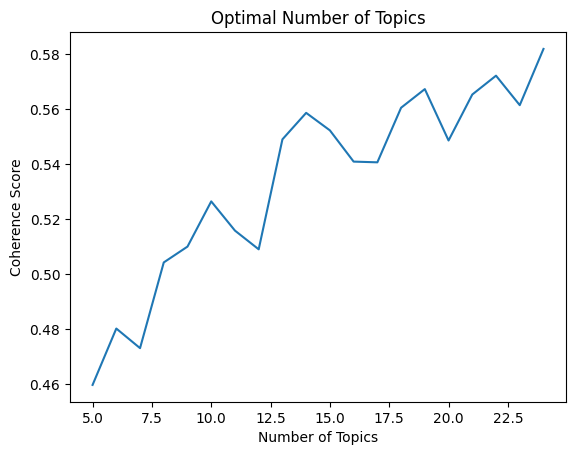

In [ ]:
# LDA
dictionary = corpora.Dictionary(df['tokenized'])

# Filtering out the extremes
dictionary.filter_extremes(no_below=1, no_above=0.5)

# Convert documents into the Bag-of-Words (BoW)
corpus = [dictionary.doc2bow(doc) for doc in tqdm(df['tokenized'], desc="Converting docs to BoW")]
topic_range = range(5, 25)
coherence_values = []
models = []

# Train LDA models for different numbers of topics and compute coherence.
for num_topics in tqdm(topic_range, desc="Training LDA models"):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         passes=5,
                         random_state=42)
    models.append(lda_model)
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=df['tokenized'],
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_values.append(coherence)
    print(f"Num Topics = {num_topics}, Coherence Score = {coherence:.4f}")
    model_filename = f"lda_model_{num_topics}_topics.model"
    lda_model.save(model_filename)
    print(f"Saved model to {model_filename}")

# Plot the coherence scores.
plt.plot(topic_range, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

### NMF - Non-Negative Matrix Factorization
Trying another method getting the topics in the Documents. The following steps were used:

1. **TF-IDF Vectorization:**  
   - The corpus is limited to 10,000 documents.  
   - The documents are preprocessed using a custom identity function (`identity_tokenizer_pickle`) for both tokenization and preprocessing, ensuring that the vectorizer can be pickled without errors.

2. **Determining the Optimal Number of Topics:**  
   - An NMF (Non-negative Matrix Factorization) model is applied over a range of topic numbers (from 5 to 30) to calculate the reconstruction error for each model.  
   - The reconstruction error quantifies how well the NMF model approximates the original TF-IDF matrix.  
   - Using the `KneeLocator` algorithm, the elbow point in the error curve is identified, indicating that adding more topics beyond this point does not significantly reduce the reconstruction error.  
   - In this case, the optimal number of topics is determined to be **21 topics**.

3. **Final NMF Model and Topic Extraction:**  
   - The NMF model is re-run using 21 topics to generate the document-topic matrix (W) and the topic-word matrix (H).  
   - The top 10 words for each of the 21 topics are extracted from the topic-word matrix to represent each topic meaningfully.  
   - A topic mapping is provided to assign descriptive labels to each topic, enhancing interpretability.

In [ ]:
# Limiting to 10K corpus
documents_tokenized = df['tokenized'].to_numpy()

# Had to add this for pickle to work properly and save the model
def identity_tokenizer_pickle(x):
    return x

# Vectorize the documents using TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer_pickle,
    preprocessor=identity_tokenizer_pickle,
    lowercase=False, max_features=10_000)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_tokenized)

# Save the tfidf_vectorizer using pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


 36%|███▌      | 9/25 [02:07<04:03, 15.22s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 44%|████▍     | 11/25 [03:43<07:32, 32.30s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 48%|████▊     | 12/25 [04:24<07:34, 34.96s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 25/25 [12:31<00:00, 30.04s/it]


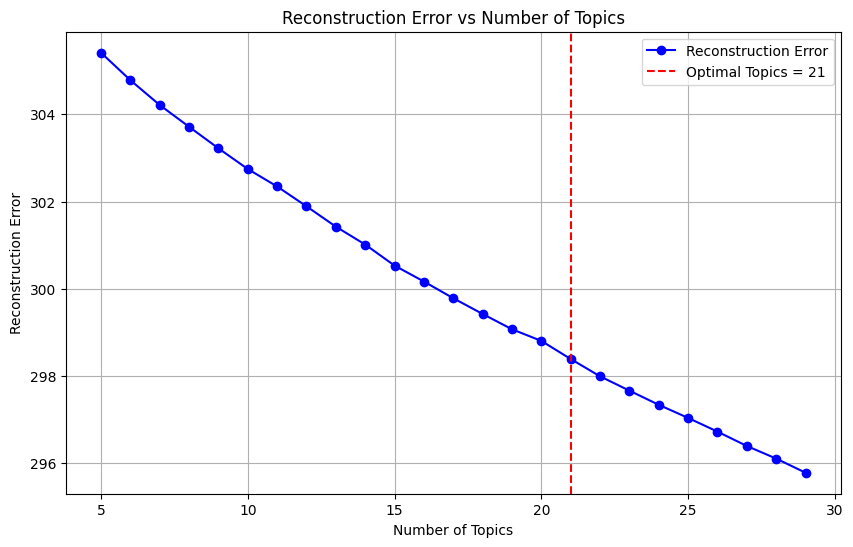

In [ ]:
# Range number of topics
topic_range = range(5, 30)

# Function to calculate NMF
def calculate_nmf(num_topics, tfidf_matrix):
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf_matrix)
    reconstruction_err = nmf_model.reconstruction_err_
    return reconstruction_err, nmf_model

# Test a range of topic numbers and store reconstruction errors
errors = []

# Calculate the reconstruction errors
for num_topics in tqdm(topic_range):
    error, model = calculate_nmf(num_topics, tfidf_matrix)
    errors.append(error)

# Find the optimal number of topics
kl = KneeLocator(topic_range, errors, curve='convex', direction='decreasing')
optimal_num_topics = kl.elbow

# Plot the reconstruction errors and the elbow point
plt.figure(figsize=(10, 6))
plt.plot(topic_range, errors, marker='o', linestyle='-', color='blue', label='Reconstruction Error')
plt.axvline(x=optimal_num_topics, color='red', linestyle='--', label=f'Optimal Topics = {optimal_num_topics}')
plt.title('Reconstruction Error vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Getting Elbow at 21 - Taking 21 as the number of topics
num_topics = 21
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(tfidf_matrix)  
H = nmf_model.components_  

# Get the topic-word matrix
topic_word_matrix = nmf_model.components_

# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame
topic_word_df = pd.DataFrame(topic_word_matrix, columns=feature_names)


In [15]:
# Display the top 10 words for each topic
top_10 = []
topic_num = []
for topic in range(num_topics):
    topic_num.append(topic+1)
    top_10 += [topic_word_df.iloc[topic].nlargest(10).index.tolist()]

topic_df = pd.DataFrame()
topic_df['Topic'] = topic_num
topic_df['top_10_words'] = top_10
#topic_df.to_csv('data_final/topic_words.csv', index=False)

Mapping topics after looking at the dataframe saved as a csv

In [ ]:
# Topic Mapping
topic_mapping = {
    'Topic_1': "Family and Society",
    'Topic_2': "Entertainment and Pop Culture",
    'Topic_3': "US Politics",
    'Topic_4': "Sports",
    'Topic_5': "Law and Crime",
    'Topic_6': "Aviation and Accidents",
    'Topic_7': "China and East Asia",
    'Topic_8': "Korea and Geopolitics",
    'Topic_9': "Crime and Law Enforcement",
    'Topic_10': "Health and Disease",
    'Topic_11': "Middle East and Conflict",
    'Topic_12': "Education and Academia",
    'Topic_13': "Middle East Politics",
    'Topic_14': "Syrian and Iraq Conflict",
    'Topic_15': "Weather and Natural Disasters",
    'Topic_16': "Sports Competitions",
    'Topic_17': "Government and Protests",
    'Topic_18': "Entertainment and Celebrity News",
    'Topic_19': "Russia and Ukraine Conflict",
    'Topic_20': "Economy and Business",
    'Topic_21': "Technology and Social Media"
}

### Mean Embedding Vector Calculation
We calculate a mean embedding vector for each of the 21 topics identified by the NMF model. Essentially, this process consolidates all words (or documents) strongly associated with a particular topic into a single, representative embedding. By averaging the TF-IDF-weighted embeddings, we capture the “central” semantic direction of each topic in the high-dimensional embedding space. As a result, each of the 21 topics now corresponds to a single vector, which helps us visualize or further analyze the underlying themes within our dataset.

In [ ]:
# Create the Topic-Document Matrix (Transpose of Document-Topic Matrix)
topic_document_matrix = pd.DataFrame(W.T, index=[f'Topic_{i+1}' for i in range(num_topics)], columns=[f'Doc_{i+1}' for i in range(len(documents_tokenized))])
topic_document_matrix = topic_document_matrix.T

# Get the top 3 topics for each document
top_3_topics_df = pd.DataFrame(columns=['Document', 'Assigned_Topic', 'Top_3_Topics'])

for i, row in tqdm(topic_document_matrix.iterrows()):
    sorted_topics = row.sort_values(ascending=False)
    top_3_topics = sorted_topics.index[:3].tolist()
    assigned_topic = top_3_topics[0]
    top_3_topics_df = pd.concat([top_3_topics_df, pd.DataFrame({
        'Document': [documents_tokenized[int(i.split('_')[1]) - 1]],
        'Assigned_Topic': [assigned_topic],
        'Top_3_Topics': [top_3_topics]
    })])

100000it [00:59, 1682.16it/s]


In [ ]:
# Assigning the max similarity topic to the document
top_3_topics_df['Assigned_Topic'] = top_3_topics_df['Assigned_Topic'].map(topic_mapping)

lst = []
for top in tqdm(top_3_topics_df['Top_3_Topics']):
    lst.append([topic_mapping[topic] for topic in top])

100%|██████████| 100000/100000 [00:00<00:00, 2234185.79it/s]


We can see the distribution of the number of articles in each topic.

**Graph Insights**
- Entertainment and Pop Culture has the max number of articles assigned
- Followed by Crime and Law Enforcement

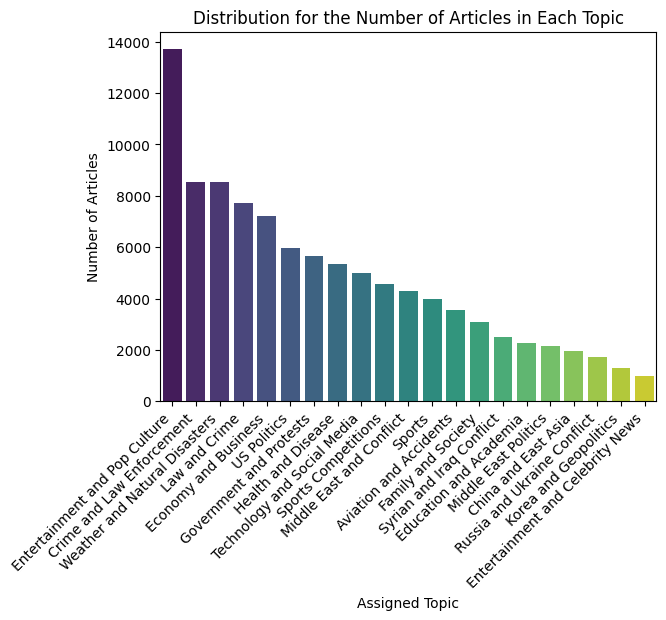

In [59]:
# Distribution for the number of articles in each topic
topic_counts = top_3_topics_df['Assigned_Topic'].value_counts()
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.xlabel("Assigned Topic")
plt.ylabel("Number of Articles")
plt.title("Distribution for the Number of Articles in Each Topic")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
top_3_topics_df['Top_3_Topics'] = lst
top_3_topics_df.reset_index(drop=True, inplace=True)
top_3_topics_df.head()

,Document,Assigned_Topic,Top_3_Topics
0,"[london, england, reuters, harry, potter, star...",Entertainment and Pop Culture,"[Entertainment and Pop Culture, Economy and Bu..."
1,"[editor, note, behind, scene, series, cnn, cor...",Health and Disease,"[Health and Disease, Entertainment and Pop Cul..."
2,"[minneapolis, minnesota, cnn, driver, minneapo...",Weather and Natural Disasters,"[Weather and Natural Disasters, Entertainment ..."
3,"[washington, cnn, doctor, remove, five, small,...",Health and Disease,"[Health and Disease, Weather and Natural Disas..."
4,"[cnn, national, football, league, indefinitely...",Law and Crime,"[Law and Crime, Weather and Natural Disasters,..."


Adding the tf-idf embeddings to the dataframe

In [ ]:
# adding tfidf embedding to the dataframe
df['tfidf_embedding'] = tfidf_matrix.toarray().tolist()

# adding topic assignment to the dataframe
df['topic_assignment'] = top_3_topics_df['Assigned_Topic']
df['top_3_topics'] = top_3_topics_df['Top_3_Topics']

In [ ]:
# Saving the file as a parquet file
df.to_parquet('data_final/datum_with_tokens_tfidf.parquet', compression='snappy')

getting the mean vectors

In [26]:
mean_vectors = {
    topic: np.mean(np.vstack(group['tfidf_embedding'].to_numpy()), axis=0)
    for topic, group in df.groupby('topic_assignment')
}

## Recommender System

Based on the mean vectors created and assignment to the documents, we are creating a recommender system that based on the user's query, takes out the cosine similarity between the query and the topic and then gives out the articles in that topic.

In [ ]:
# It returns the TF-IDF embeddings for the new query sent by the user
def preprocess_new(text, tfidf_vectorizer, stop_words, lem):
    cleaned_article = clean_text(text).split()
    tokens_cleaned, _,_ = lemmetizer(cleaned_article, set(), defaultdict(int), stop_words, lem)
    return tfidf_vectorizer.transform([tokens_cleaned])

# A runall function for getting the articles with the most similar topic
def new_query(query, df, tfidf_vectorizer, mean_vectors):
    stop_words = set(stopwords.words('english'))
    lem = WordNetLemmatizer()

    # Getting the cosine similarities
    similarities = {
        topic: cosine_similarity(mean_vector.reshape(1, -1), 
                                 preprocess_new(query, tfidf_vectorizer, stop_words, lem))[0][0]
        for topic, mean_vector in mean_vectors.items()
    }
    print("Got the similarities with the topics")

    # Find the topic with the maximum similarity
    max_topic = max(similarities, key=similarities.get)
    max_similarity = similarities[max_topic]

    print(f"\nMost Similar Topic: {max_topic} (Similarity: {max_similarity:.4f})")

    #getting all the max similarity articles
    return df[df['topic_assignment'] == max_topic][['article', 'highlights']].reset_index(drop=True)



In [38]:
query = "I really like comedy movies"
new_query(query, df, tfidf_vectorizer, mean_vectors)

Got the similarities with the topics

Most Similar Topic: Entertainment and Pop Culture (Similarity: 0.1414)


,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,"LOS ANGELES, California (Reuters) -- ""To insu...","Because of troubles, Lindsay Lohan likely diff..."
2,"LONDON, England (CNN) -- Prince Harry led trib...","Prince Harry describes Princess Diana as ""the ..."
3,"1. ""Für Elise"" Bob Dylan wrote ""It Ain't Me, B...",Several famous songs written by men for a woma...
4,(Real Simple) -- Here are five great ways to e...,Real Simple tips can add up to great summer . ...
...,...,...
13706,"By . Hannah Roberts . PUBLISHED: . 19:35 EST, ...",Self-published book has knocked the Dukan Diet...
13707,"By . Graham Smith . PUBLISHED: . 06:13 EST, 15...",Fleming approached Hitchcock by sending a tele...
13708,"By . Emma Clark . PUBLISHED: . 08:00 EST, 25 J...",Charlie Gillion and his wife Penelope shun the...
13709,"By . Liz Hull . PUBLISHED: . 06:20 EST, 18 Jul...",Emyr Davies admitted 12 separate charges of un...


In [49]:
query = "Give me the articles on sports"
new_query(query, df, tfidf_vectorizer, mean_vectors)

Got the similarities with the topics

Most Similar Topic: Sports Competitions (Similarity: 0.0639)


,article,highlights
0,"QUEBEC, Canada -- Third seed Julia Vakulenko w...",Julia Vakulenko has reached her first final on...
1,"PARIS, France -- World number three Novak Djok...",World No. 3 Novak Djokovic beaten in the secon...
2,"SHANGHAI, China -- Championship leader Lewis H...",Lewis Hamilton fails to clinch world title aft...
3,"LONDON, England (CNN) -- There are some circui...",Re-designed Fuji Speedway to host its first Ja...
4,"PARIS, France -- France lock Sebastien Chabal ...",France lock Sebastien Chabal cited for a dange...
...,...,...
4566,"By . James Tozer . PUBLISHED: . 12:42 EST, 31 ...",The iconic DBR1/2 won the 1959 Le Mans 24-hour...
4567,"By . Martin Robinson . PUBLISHED: . 05:28 EST,...",Britain's first grand slam winner for 76 years...
4568,"By . Richard Shears . UPDATED: . 07:59 EST, 21...","Julia Gillard, a self-confessed republican, ch..."
4569,"By . Adam Shergold . PUBLISHED: . 11:36 EST, 2...",Scottish comedian renews long-running feud wit...


# Conclusion
In this project, we applied Non-negative Matrix Factorization (NMF) to a corpus of news articles to derive clear, data-driven topics, each represented by a mean embedding vector. We then used cosine similarity to match new articles to the existing topic vectors, enabling effective and robust content recommendations. This approach not only revealed the underlying thematic structures in our news data but also provided a mechanism to personalize user experiences, highlight trending stories, and streamline editorial strategies. By integrating topic modeling, embedding techniques, and similarity measures, we developed a robust method to identify, organize, and recommend news articles that closely align with user interests, ultimately driving higher engagement and supporting more informed business decisions.

## Future Steps

In the future, we would like to enhance the model to handle more robust queries and include more topics and articles in the same so that we are able to give the users a better experience with our recommender system.